In [71]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import random
random.seed(56)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import StratifiedKFold

import lightgbm
import optuna
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

## Dataset

In [457]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [458]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [459]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### Y Class & Y Quality

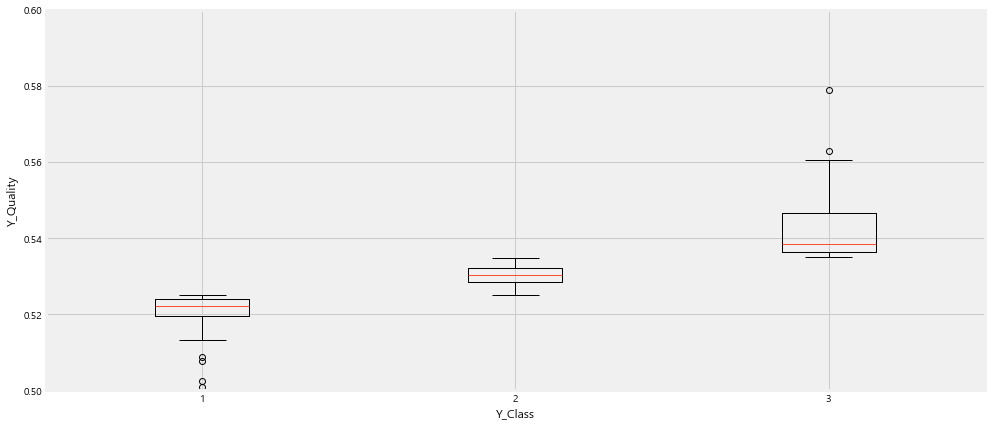

In [460]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [461]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [462]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code value counts

In [463]:
# Product Code는 3가지로 이루어져 있다.
for code in train['PRODUCT_CODE'].unique():
    print(code, len(train[train['PRODUCT_CODE']==code]))

A_31 249
T_31 343
O_31 6


### TimeStamp

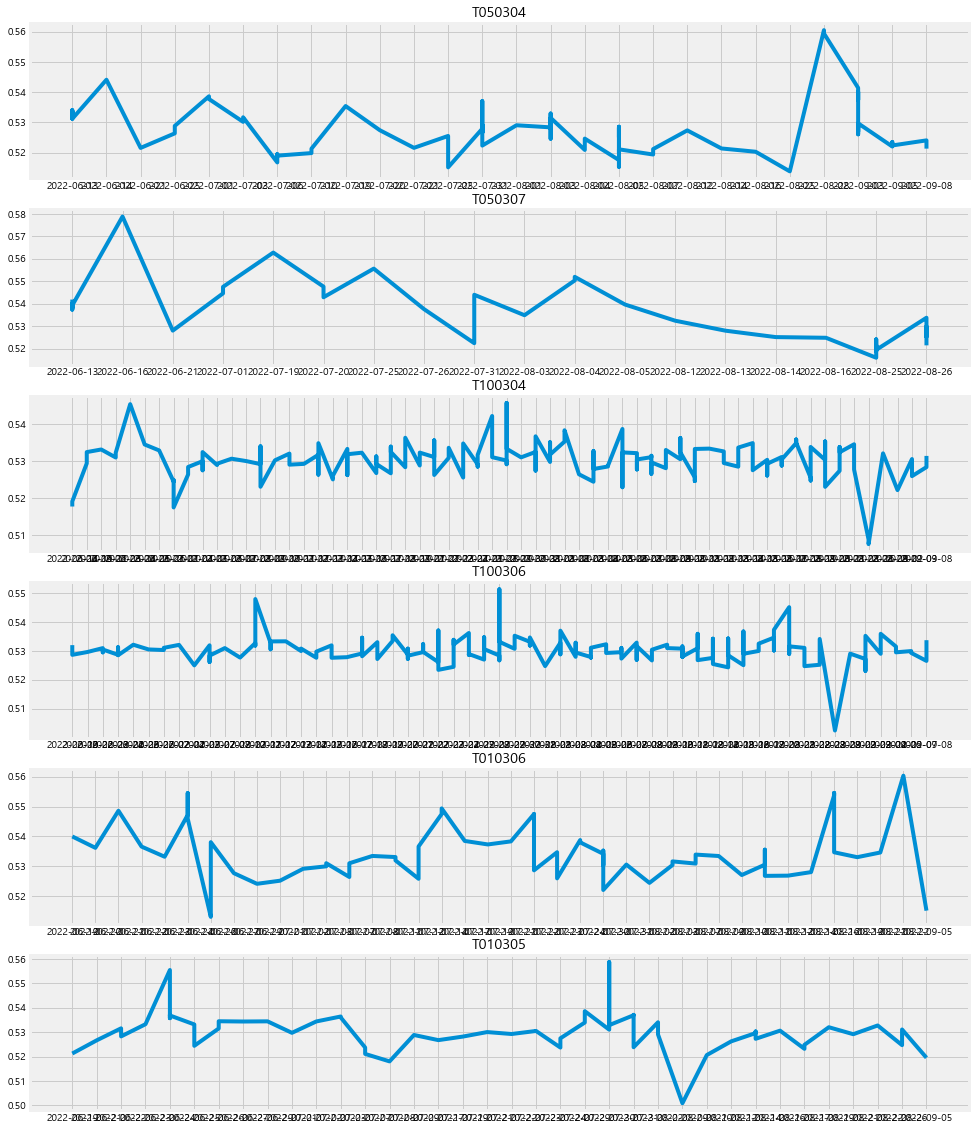

In [464]:
# Line 비교
rcParams['figure.figsize'] = 15, 20

for i, line in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==line]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%Y-%m-%d')
    plt.plot(tmp['TIMESTAMP'], tmp['Y_Quality'])
    plt.title(line)
plt.show()

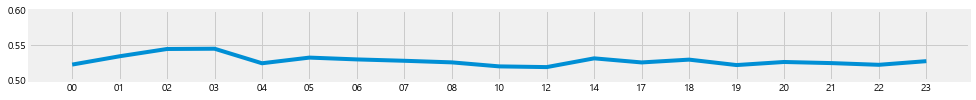

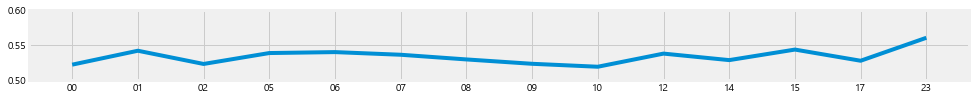

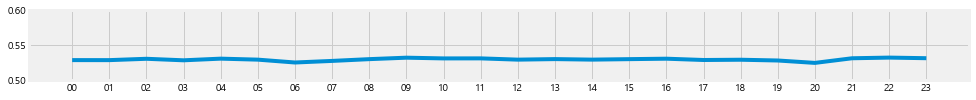

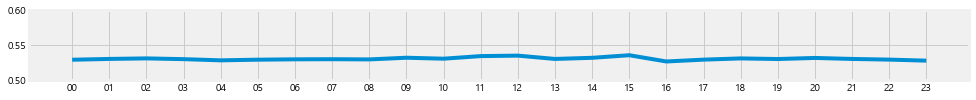

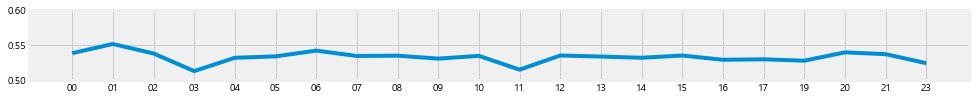

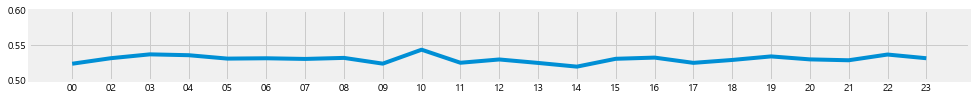

In [465]:
# 시간대별 Line의 Quality 비교
rcParams['figure.figsize'] = 15, 9

for i, line in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==line]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%H')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.ylim(0.5, 0.6)
    plt.show()

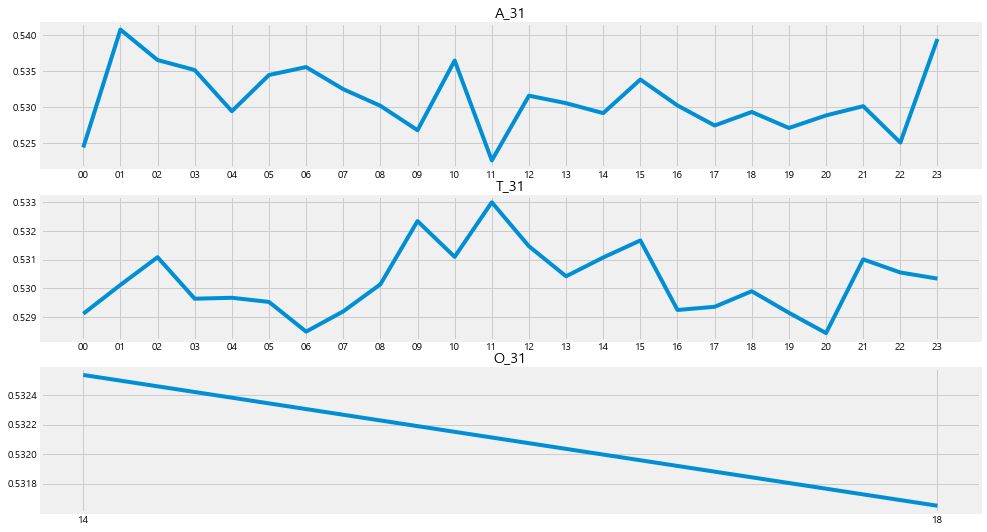

In [466]:
# 시간대별 Product Code의 Quality 비교
rcParams['figure.figsize'] = 15, 9

for i, code in enumerate(train.PRODUCT_CODE.unique()):
    plt.subplot(len(train.PRODUCT_CODE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==code]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%H')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(code)
plt.show()

In [467]:
# 시간대별 영향력이 있어보인다.
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%H')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,05,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,05,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,05,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,05,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,05,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [468]:
len(train.columns)

2881

In [434]:
# for x in train.columns[6:]:
#     if train[train[x].isnull()]['PRODUCT_CODE'].nunique() + train[train[x].notnull()]['PRODUCT_CODE'].nunique() != 3:
#         train.drop(columns=[x], inplace=True)

# len(train.columns)

560

In [469]:
train.fillna(0, inplace=True)
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,05,T050304,A_31,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,TRAIN_001,2,0.541819,05,T050307,A_31,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,TRAIN_002,1,0.531267,05,T050304,A_31,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,TRAIN_003,2,0.537325,05,T050307,A_31,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,TRAIN_004,1,0.531590,05,T050304,A_31,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,14,T100306,T_31,2.0,95.0,0.0,45.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
594,TRAIN_594,0,0.524022,22,T050304,A_31,0.0,0.0,0.0,0.0,...,49.47,53.07,50.89,55.10,66.49,1.0,0.0,0.0,0.0,0.0
595,TRAIN_595,0,0.521289,22,T050304,A_31,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
596,TRAIN_596,1,0.531375,14,T100304,O_31,40.0,94.0,0.0,45.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


### astype

In [470]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2871        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 2881, dtype: object

In [471]:
train['TIMESTAMP'] = train['TIMESTAMP'].astype('int')
train['TIMESTAMP'].dtypes

dtype('int32')

### data split & astype

In [472]:
train.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train.head()

,Y_Class,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,5,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,2,5,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,1,5,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,2,5,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,1,5,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0


In [473]:
x_train = train.drop(columns=['Y_Class'])
y_train = train['Y_Class']

test = test[x_train.columns]
test.fillna(0, inplace=True)
test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%H').astype('int')

x_train['LINE'] = x_train['LINE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

x_train['PRODUCT_CODE'] = x_train['PRODUCT_CODE'].astype('category')
test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')

test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Standard Scaler

In [475]:
from sklearn.preprocessing import StandardScaler
stscaler = StandardScaler().fit(x_train[x_train.columns[3:]])
x_train[x_train.columns[3:]] = stscaler.transform(x_train[x_train.columns[3:]])
test[test.columns[3:]] = stscaler.transform(test[test.columns[3:]])
test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,T100306,T_31,0.127626,0.818890,0.0,0.844670,0.766018,0.0,0.927147,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
1,2,T100304,T_31,0.127626,0.797612,0.0,0.844670,0.960697,0.0,0.680110,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
2,8,T100304,T_31,0.127626,0.840168,0.0,0.844670,0.960697,0.0,0.680110,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
3,10,T010305,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
4,11,T010306,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


### PCA

,pc_ratio
pc1,0.590884
pc2,0.224722
pc3,0.068269
pc4,0.013511
pc5,0.011401


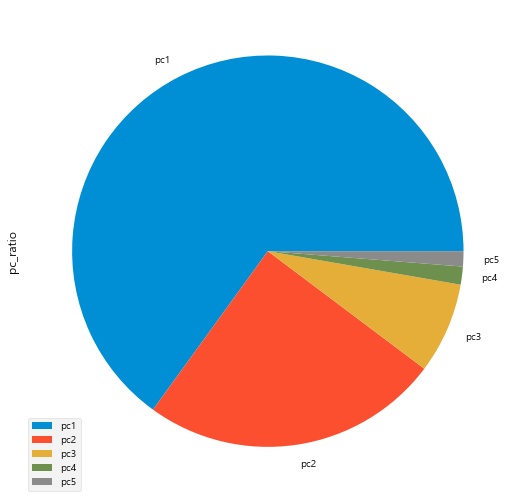

In [476]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train[x_train.columns[3:]])
ratio = pca.explained_variance_ratio_

df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
df_v.plot.pie(y='pc_ratio')
df_v

In [477]:
n = 3
pca = PCA(n_components=n)
pc = pca.fit_transform(x_train[x_train.columns[3:]])
xtrain_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
xtrain_pca.head()

,pc1,pc2,pc3
0,78.477344,39.950503,-22.739030
1,81.930609,44.301906,-27.843096
2,78.814129,39.601911,-22.517002
3,79.836864,41.394344,-23.123791
4,78.252519,39.828358,-22.790516


In [480]:
pc = pca.transform(test[test.columns[3:]])
test_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
test_pca.head()

,pc1,pc2,pc3
0,-30.343488,8.093183,-0.190465
1,-30.242830,8.021313,-0.184517
2,-30.465126,8.177994,-0.196885
3,20.412686,-42.166546,-6.110419
4,20.106797,-41.726529,-6.093019


In [481]:
x_train = pd.concat([x_train[x_train.columns[:3]], xtrain_pca], axis=1)
test = pd.concat([test[test.columns[:3]], test_pca], axis=1)
x_train.head()

,TIMESTAMP,LINE,PRODUCT_CODE,pc1,pc2,pc3
0,5,T050304,A_31,78.477344,39.950503,-22.739030
1,5,T050307,A_31,81.930609,44.301906,-27.843096
2,5,T050304,A_31,78.814129,39.601911,-22.517002
3,5,T050307,A_31,79.836864,41.394344,-23.123791
4,5,T050304,A_31,78.252519,39.828358,-22.790516


### Optuna

In [488]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 256),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    clf = lightgbm.LGBMClassifier(**params)
    
    f1_list = []
    
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))    
    
    return np.mean(f1_list)

In [489]:
# optuna 튜닝
study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=50, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")

trial = study.best_trial

print("  mae : {}".format(trial.value))
print("  Best hyperparameters: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-02-02 20:42:53,997] A new study created in memory with name: no-name-4f1cba01-9f98-46cb-828a-0076fbf62dd0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-02-02 20:42:56,230] Trial 0 finished with value: 0.47435860809050145 and parameters: {'max_depth': 22, 'num_leaves': 145, 'learning_rate': 0.9145970842649432, 'n_estimators': 2800, 'colsample_bytree': 0.5435733756067556, 'colsample_bynode': 0.9745770950740567, 'reg_lambda': 0.2436585136246641, 'reg_alpha': 0.0545670797756471, 'min_child_weight': 15, 'min_child_samples': 66}. Best is trial 0 with value: 0.47435860809050145.
[I 2023-02-02 20:42:56,658] Trial 1 finished with value: 0.5327390190797765 and parameters: {'max_depth': 18, 'num_leaves': 5, 'learning_rate': 0.4101063582755607, 'n_estimators': 1000, 'colsample_bytree': 0.9100906959637957, 'colsample_bynode': 0.5295484843993592, 'reg_lambda': 0.05227995542813676, 'reg_alpha': 0.7592511616575551, 'min_child_weight': 10, 'min_child_samples': 36}. Best is trial 1 with value: 0.5327390190797765.
[I 2023-02-02 20:42:57,310] Trial 2 finished with value: 0.5206028110062799 and parameters: {'max_depth': 59, 'num_leaves': 6, 'learn

[I 2023-02-02 20:43:12,677] Trial 19 finished with value: 0.5354535495399676 and parameters: {'max_depth': 105, 'num_leaves': 25, 'learning_rate': 0.31542086358643673, 'n_estimators': 1600, 'colsample_bytree': 0.683397712173479, 'colsample_bynode': 0.7311638716081242, 'reg_lambda': 0.6538920437885412, 'reg_alpha': 0.14220723479556974, 'min_child_weight': 4, 'min_child_samples': 62}. Best is trial 13 with value: 0.5658316269777746.
[I 2023-02-02 20:43:14,600] Trial 20 finished with value: 0.5081126004096745 and parameters: {'max_depth': 184, 'num_leaves': 87, 'learning_rate': 0.1100747984733634, 'n_estimators': 2400, 'colsample_bytree': 0.8012786241669015, 'colsample_bynode': 0.863337707577888, 'reg_lambda': 0.2962276646176764, 'reg_alpha': 0.43839393059761994, 'min_child_weight': 7, 'min_child_samples': 43}. Best is trial 13 with value: 0.5658316269777746.
[I 2023-02-02 20:43:15,165] Trial 21 finished with value: 0.5480335505181089 and parameters: {'max_depth': 58, 'num_leaves': 13, 'l

[I 2023-02-02 20:43:31,033] Trial 38 finished with value: 0.5541528488655272 and parameters: {'max_depth': 26, 'num_leaves': 8, 'learning_rate': 0.35100971069561243, 'n_estimators': 2700, 'colsample_bytree': 0.6177634716901212, 'colsample_bynode': 0.6216906442010328, 'reg_lambda': 0.046388619901340127, 'reg_alpha': 0.7589391914231541, 'min_child_weight': 5, 'min_child_samples': 10}. Best is trial 32 with value: 0.5794661676390394.
[I 2023-02-02 20:43:31,829] Trial 39 finished with value: 0.5388671454647833 and parameters: {'max_depth': 252, 'num_leaves': 7, 'learning_rate': 0.3661529064282991, 'n_estimators': 2600, 'colsample_bytree': 0.6071136810399823, 'colsample_bynode': 0.6166587137504267, 'reg_lambda': 0.014725355731332863, 'reg_alpha': 0.7651974077830438, 'min_child_weight': 5, 'min_child_samples': 9}. Best is trial 32 with value: 0.5794661676390394.
[I 2023-02-02 20:43:34,369] Trial 40 finished with value: 0.4867794916321869 and parameters: {'max_depth': 203, 'num_leaves': 59, '

In [498]:
study.best_params

{'max_depth': 34,
 'num_leaves': 26,
 'learning_rate': 0.1753534616250424,
 'n_estimators': 2800,
 'colsample_bytree': 0.5807828340150588,
 'colsample_bynode': 0.9022524336655924,
 'reg_lambda': 0.7323009973043658,
 'reg_alpha': 0.2670053944144693,
 'min_child_weight': 6,
 'min_child_samples': 30}

In [492]:
clf = lightgbm.LGBMClassifier(**study.best_params)
clf.fit(x_train, y_train, verbose=0)
subm['Y_Class'] = clf.predict(test)
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,1
3,TEST_003,1
4,TEST_004,2


In [493]:
subm.Y_Class.value_counts()

1    232
0     46
2     32
Name: Y_Class, dtype: int64

In [ ]:
###Y_Quality를 예측->proba로 이용해보자

In [456]:
#subm.to_csv('submission5.csv', index=False) # optuna_micro_lgbm_pca2_partlyx0

In [497]:
#subm.to_csv('submission6.csv', index=False) # optuna_macro_lgbm_pca3_allx0_stscaler